In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
from tqdm.notebook import tqdm
from scipy.special import gamma

from joblib import Parallel, delayed

import datetime

In [2]:
input_data = pd.read_csv('STORAGE_data/es-1min_FULL.csv')
input_data.index = pd.to_datetime(input_data.date + ' ' + input_data.time)
input_data

,date,time,open,high,low,close
2011-12-19 09:30:00,12/19/2011,9:30:00,1215.875,1216.375,1215.625,1215.875
2011-12-19 09:31:00,12/19/2011,9:31:00,1215.875,1217.125,1215.875,1217.125
2011-12-19 09:32:00,12/19/2011,9:32:00,1217.125,1217.875,1217.125,1217.625
2011-12-19 09:33:00,12/19/2011,9:33:00,1217.625,1218.375,1217.625,1218.125
2011-12-19 09:34:00,12/19/2011,9:34:00,1218.125,1218.375,1217.625,1217.875
...,...,...,...,...,...,...
2015-12-16 16:10:00,12/16/2015,16:10:00,2070.125,2070.375,2069.875,2070.125
2015-12-16 16:11:00,12/16/2015,16:11:00,2070.125,2070.875,2069.125,2069.250
2015-12-16 16:12:00,12/16/2015,16:12:00,2069.250,2072.125,2069.125,2072.125
2015-12-16 16:13:00,12/16/2015,16:13:00,2072.125,2072.625,2071.625,2072.000


In [3]:
data = input_data.drop(['date', 'time'], axis=1)

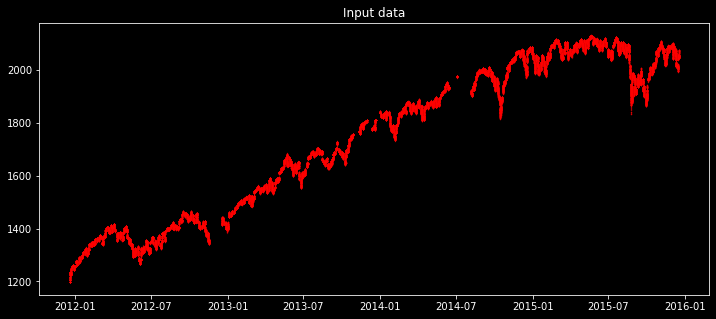

In [4]:
plt.style.use('dark_background')
plt.figure(figsize=(12,5))
plt.plot(data.close, 'o', markersize=.3, color='red', alpha=.6)
plt.title('Input data')
plt.show()

In [5]:
def _start_duplicates_removing(inp_data):
    #   Clean duplicates
    ret_data = inp_data.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
    #   Check success of cleaning
    assert len(ret_data.index) == len(ret_data.index.unique())
    print(f'Duplicates at {1 - (ret_data.shape[0] / inp_data.shape[0]):.2%} of data')
    return ret_data

def normalize_data(inp_data: pd.DataFrame, show=True):
    #   Calculate the right numbers of observations intra day
    NORMAL_MINUTES = (15 - 9) * 60 + 30
    #   Checks for duplicates
    if show:
        plt.style.use('dark_background')
        plt.figure(figsize=(12,8))
        plt.subplot(2,1,1)
        plt.plot(inp_data.close, 'o', markersize=.3, color='red', alpha=.6)
        plt.title('Input data')

    if len(inp_data.index) != len(inp_data.index.unique()):
        inp_data = _start_duplicates_removing(inp_data)
    #   In data not of all information about trade-day. For example at date 2011-12-19 data ends at 15:59. At date 2015-12-19 data ends at 16:14. Notice that normal trade day ends at 16:30.
    #   At start lets drop lines with days with zero observations.
    # mask = ~np.in1d(inp_data.index.date,inp_data.resample('1D').count().query(f'open < {NORMAL_MINUTES}').index.date)
    #
    # if show:
    #     plt.subplot(2,1,2)
    #     plt.plot(inp_data.loc[mask,:].close, 'o', markersize=.3, color='red', alpha=.6)
    #     plt.title('Cut data')
    #     plt.show()
    # #   Shows percent of "bad" dotes
    # print(f"Bad days at {1 - (len(mask) / len(inp_data)):.2%} observations")
    # return inp_data.loc[mask,:]
    return inp_data

Duplicates at 6.18% of data


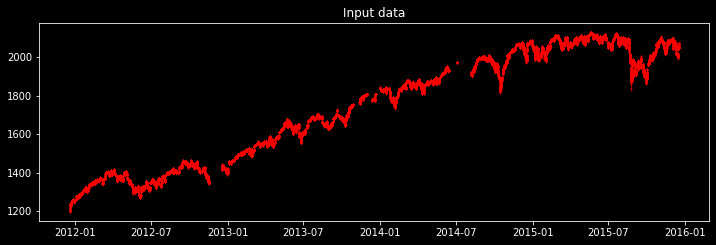

In [11]:
nrm = normalize_data(data)

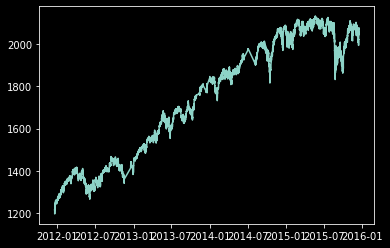

In [7]:
nrm = data.dropna()
plt.plot(nrm.close)

In [106]:
THRESHOLD = 0.014
#THRESHOLD = 0.0001

def order_logic(OP, CL, X):
    if (OP / CL) - 1 > X:
        return True, 'LONG'
    if (OP / CL) - 1 < -1 * X:
        return True, 'SHORT',
    else:
        return False, 'FALSE',

# def order_return(inp_data: pd.DataFrame, MONEY, OP, TYPE):
#     SLIPADGE = 10
#     CLOSE = inp_data.iloc[-1].close
#     if TYPE == 'SHORT':
#         return (2 * MONEY) - ((MONEY / OP) * CLOSE) - SLIPADGE
#     if TYPE == 'LONG':
#         return (MONEY / OP) * CLOSE - SLIPADGE

def order_return(inp_data: pd.DataFrame, MONEY, OP, TYPE, INDEX):
    loss_data = inp_data.loc[INDEX:]
    SLIPADGE = 20
    BATCH = 1
    LOSS_PERCENT = 0.05
    CLOSE = inp_data.iloc[-1].close

    if TYPE == 'SHORT':
        for _ in loss_data.index:
            if (loss_data.loc[_,:].open / OP) - 1 > LOSS_PERCENT:
                return BATCH * (OP - loss_data.loc[_,:].close) - SLIPADGE
        return BATCH * (OP - CLOSE) - SLIPADGE
    if TYPE == 'LONG':
        for _ in loss_data.index:
            if (loss_data.loc[_,:].open / OP) - 1 < -1 * LOSS_PERCENT:
                return BATCH * (loss_data.loc[_,:].close - OP) - SLIPADGE
        return BATCH * (CLOSE - OP) - SLIPADGE

MONEY = 10
MONEY_ARRAY = list()
DATES_ARRAY = list()


ALL_index_array = nrm.index
for index in tqdm(np.unique(nrm.index[:].date)):
    _true_index = pd.to_datetime(index) + datetime.timedelta(hours=14, minutes=30, seconds=0) # '2012-01-01' -> '2012-01-01 14:30:00'
    CURRENT = nrm.loc[_true_index,:].open
    back_index = _true_index - datetime.timedelta(days=1) + datetime.timedelta(minutes=30)
    forward_index = _true_index + datetime.timedelta(minutes=59)
    if (back_index in ALL_index_array) and (forward_index in ALL_index_array):
        DAY_BACK_CLOSE = nrm.loc[back_index,:].close
        DAY_CURRENT_CLOSE = nrm.loc[forward_index, :].close
        CURRENT_data = nrm.loc[index.strftime('%Y-%m-%d'): index.strftime('%Y-%m-%d')]
        if order_logic(CURRENT, DAY_BACK_CLOSE, THRESHOLD)[0]:
            TYPE = order_logic(CURRENT, DAY_BACK_CLOSE, THRESHOLD)[1]
            MONEY = MONEY + order_return(CURRENT_data, MONEY, CURRENT, TYPE, _true_index)
            if MONEY < 0:
                MONEY = 10
            MONEY_ARRAY.append(MONEY)
            DATES_ARRAY.append(index)

MONEY_ARRAY

  0%|          | 0/919 [00:00<?, ?it/s]

KeyError: Timestamp('2012-07-03 14:30:00')

In [8]:
def sharpe(MNY_RET):
    MNY_RET = np.array(MNY_RET)
    #LMNY = (np.diff(MNY_RET) / MNY_RET[:-1])
    LMNY = np.diff(np.log(MNY_RET))
    print(LMNY[:10])
    SHARPE = np.nanmean(LMNY)/ np.nanstd(LMNY)
    print('SHARPE:', SHARPE)
    return SHARPE

sharpe(MONEY_ARRAY)

[        nan         nan         nan         nan         nan  0.5389965
 -0.30809094  0.50669339 -0.68695521 -0.38711597]
SHARPE: 0.09265512588761537


/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_535/3471237817.py:4: RuntimeWarning: invalid value encountered in log
  LMNY = np.diff(np.log(MNY_RET))


0.09265512588761537

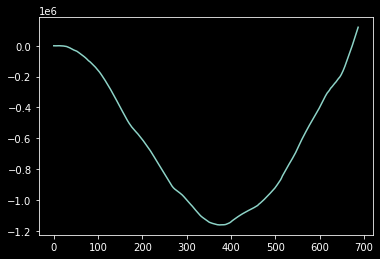

In [9]:
plt.plot(np.cumsum(MONEY_ARRAY))

In [16]:
nrm.resample('1D').first()

,open,high,low,close
index,,,,
2011-12-19,1215.875,1216.375,1215.625,1215.875
2011-12-20,1217.125,1218.125,1217.125,1218.125
2011-12-21,1235.125,1235.875,1234.375,1235.375
2011-12-22,1241.875,1241.875,1240.375,1240.375
2011-12-23,1252.625,1252.875,1252.375,1252.875
...,...,...,...,...
2015-12-12,NaN,NaN,NaN,NaN
2015-12-13,NaN,NaN,NaN,NaN
2015-12-14,2012.875,2013.625,2011.125,2013.375


In [49]:
THRESHOLD = 0.014
#THRESHOLD = 0.0001

def order_logic(OP, CL, X):
    if (OP / CL) - 1 > X:
        return True, 'LONG'
    if (OP / CL) - 1 < -1 * X:
        return True, 'SHORT',
    else:
        return False, 'FALSE',



def order_return(inp_data: pd.DataFrame, OP, TYPE, INDEX):
    loss_data = inp_data.loc[INDEX:]
    SLIPADGE = 20
    BATCH = 50
    LOSS_PERCENT = 1
    CLOSE = inp_data.iloc[-1].close
    #print(f"TYPE:{TYPE}| START:{OP}| CLOSE:{CLOSE}")
    if TYPE == 'SHORT':
        for _ in loss_data.index:
            if (loss_data.loc[_,:].open / OP) - 1 > LOSS_PERCENT:
                return BATCH * (OP - loss_data.loc[_,:].close) - SLIPADGE
        return BATCH * (OP - CLOSE) - SLIPADGE
    if TYPE == 'LONG':
        for _ in loss_data.index:
            if (loss_data.loc[_,:].open / OP) - 1 < -1 * LOSS_PERCENT:
                return BATCH * (loss_data.loc[_,:].close - OP) - SLIPADGE
        return BATCH * (CLOSE - OP) - SLIPADGE

MONEY = 0
MONEY_ARRAY = list()
DATES_ARRAY = list()


ALL_index_array = nrm.index
ALL_index_dates_array = np.unique(nrm.index.date)
#for _ARROW_, index in enumerate(tqdm(np.unique(nrm.index[:].date)[300:302])):
for _ARROW_, index in enumerate(tqdm(np.unique(nrm.index[:].date)[2:])):
    print(index)
    _true_index = nrm.loc[index.strftime('%Y-%m-%d')].iloc[-1].name - datetime.timedelta(hours=1)
    if (index - datetime.timedelta(days=1)) in ALL_index_dates_array:
        print('+')
        back_index = nrm.loc[(index - datetime.timedelta(days=1)).strftime('%Y-%m-%d')].iloc[-1].name
        forward_index = nrm.loc[index.strftime('%Y-%m-%d')].iloc[-1].name
        print(_true_index)
        print(nrm.loc[_true_index:,:])
        print(nrm.loc[_true_index:,:].iloc[0])
        #CURRENT = nrm.loc[_true_index,:].open
        DAY_BACK_CLOSE = nrm.loc[back_index,:].close
        DAY_CURRENT_CLOSE = nrm.loc[forward_index, :].close
        #print(F"ARROW: {_ARROW_} TRUE: {_true_index}, back: {back_index} forward: {forward_index}")
        CURRENT_data = nrm.loc[index.strftime('%Y-%m-%d')]
        if order_logic(CURRENT, DAY_BACK_CLOSE, THRESHOLD)[0]:
            TYPE = order_logic(CURRENT, DAY_BACK_CLOSE, THRESHOLD)[1]
            MONEY = MONEY + order_return(CURRENT_data, CURRENT, TYPE, _true_index)
            if MONEY < 0:
                MONEY = 0
            MONEY_ARRAY.append(MONEY)
            DATES_ARRAY.append(index)

print(len(MONEY_ARRAY))

  0%|          | 0/916 [00:00<?, ?it/s]

2011-12-21
+
2011-12-21 14:59:00
                         open      high       low     close
2011-12-21 15:01:00  1232.875  1232.875  1231.875  1232.625
2011-12-21 15:04:00  1232.875  1233.375  1232.625  1233.125
2011-12-21 15:05:00  1233.125  1233.875  1233.125  1233.875
2011-12-21 15:06:00  1233.875  1233.875  1233.375  1233.625
2011-12-21 15:08:00  1233.625  1233.875  1233.375  1233.375
...                       ...       ...       ...       ...
2015-12-16 16:07:00  2072.125  2072.875  2071.375  2071.375
2015-12-16 16:11:00  2070.125  2070.875  2069.125  2069.250
2015-12-16 16:12:00  2069.250  2072.125  2069.125  2072.125
2015-12-16 16:13:00  2072.125  2072.625  2071.625  2072.000
2015-12-16 16:14:00  2072.000  2072.375  2071.125  2072.125

[140374 rows x 4 columns]
open     1232.875
high     1232.875
low      1231.875
close    1232.625
Name: 2011-12-21 15:01:00, dtype: float64


KeyError: Timestamp('2011-12-21 14:59:00')

In [21]:
MONEY_ARRAY

[92.5,
 235.0,
 265.0,
 382.5,
 475.0,
 530.0,
 535.0,
 440.0,
 457.5,
 256.25,
 367.5,
 472.5,
 265.0,
 182.5,
 312.5,
 242.5,
 28.75,
 21.25,
 26.25,
 43.75,
 0,
 0,
 0,
 5.0,
 0,
 17.5,
 35.0,
 127.5,
 313.75,
 268.75,
 261.25,
 116.25,
 83.75,
 1.25,
 31.25,
 686.25,
 591.25,
 583.75,
 563.75,
 556.25,
 486.25,
 453.75,
 258.75,
 26.25,
 0,
 0,
 0,
 80.0,
 0,
 5.0,
 272.5,
 190.0,
 295.0,
 112.5,
 0,
 42.5,
 110.0,
 77.5,
 0,
 0,
 0,
 0,
 67.5,
 0,
 105.0,
 0,
 280.0,
 647.5,
 727.5,
 445.0,
 0,
 0,
 0,
 55.0,
 135.0,
 115.0,
 395.0,
 0,
 105.0,
 341.25,
 452.5,
 820.0,
 800.0,
 730.0,
 497.5,
 802.5,
 757.5,
 662.5,
 755.0,
 110.0,
 302.5,
 395.0,
 150.0,
 80.0,
 0,
 92.5,
 160.0,
 77.5,
 195.0,
 162.5,
 105.0,
 0,
 0,
 17.5,
 10.0,
 215.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 30.0,
 35.0,
 77.5,
 0,
 80.0,
 0,
 42.5,
 60.0,
 90.0,
 151.25,
 231.25,
 161.25,
 28.75,
 0,
 0,
 355.0,
 435.0,
 377.5,
 482.5,
 175.0,
 280.0,
 310.0,
 515.0,
 482.5,
 387.5,
 455.0,
 535.0,
 540.0,
 420.0,
 412

In [23]:
nrm = data.drop_duplicates().dropna()

In [112]:
def sharpe(MNY_RET):
    MNY_RET = np.array(MNY_RET)
    #LMNY = (np.diff(MNY_RET) / MNY_RET[:-1])
    LMNY = np.diff(MNY_RET)
    print(LMNY[:10])
    SHARPE = np.nanmean(LMNY)/ np.nanstd(LMNY)
    print('SHARPE:', SHARPE)
    return SHARPE

sharpe(MONEY_ARRAY)

[]
SHARPE: nan


/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_535/431755709.py:6: RuntimeWarning: Mean of empty slice
  SHARPE = np.nanmean(LMNY)/ np.nanstd(LMNY)
/Users/molozey/Desktop/algo/venv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


nan